# 1D GZ plotting code

In [9]:
import numpy as np
import os
from functional_hierarchical_tensor_fourier import FunctionalHierarchicalTensorFourier
from functional_hierarchical_tensor_sketch import hier_tensor_sketch
import matplotlib.pyplot as plt

d = 256
L = 8
deg = 15


# Load data
data_path = f"./Data_deposit_script/Saved_Data/1D_GZ_data_d_{d}.npz"  # This is the path from the previous code

if os.path.exists(data_path):
    with np.load(data_path) as data:
        all_samples = data['samples'][:, 1:-1]
else:
    raise ValueError(f"No data found at path {data_path}")

# Normalize range to [-1, 1]
y = all_samples / 2.5
y = y[:6000, :]

# Hierarchical Tensor Sketching
core_data_path = f"./Data_deposit_script/Saved_Data/1D_GZ_data_d_{d}_solved_core.npz"
with np.load(core_data_path, allow_pickle=True) as data:
#     print(data.files)
#     print(data['c'])
    c = data['c'].item()

htn_obtained = FunctionalHierarchicalTensorFourier(d = d, L = L, c = c, deg = deg, ghost_pt = [])




# Parameters for columns
col1, col2 = 59, 15

# Create a grid
n_grid = 80
xx, yy = np.linspace(-1, 1, n_grid), np.linspace(-1, 1, n_grid)
X, Y = np.meshgrid(xx, yy)


# Pre-allocate the heatmap matrix
heatmap_1D = np.zeros((n_grid, n_grid))

x = np.zeros([n_grid*n_grid, d])
for i in range(n_grid):
    for j in range(n_grid):
        z_val = np.array([[X[i, j], Y[i, j]]])
        x[j*n_grid + i, [col1, col2]] = z_val
evaluated_marginal =  htn_obtained.evaluate_marginal(x, mask=[x + 1 for x in range(d) if not x in [col1, col2]])
for i in range(n_grid):
    for j in range(n_grid):
        heatmap_1D[i, j] = evaluated_marginal[i*n_grid + j]

heatmap_1D /= heatmap_1D.sum()
# Extract the particle positions
particles = y[:, [col1, col2]]

# Create a 2D histogram for particles
hist_1D, xedges, yedges = np.histogram2d(particles[:, 0], particles[:, 1], bins=n_grid, range=[[-1, 1], [-1, 1]])
hist_1D /= hist_1D.sum()  # Normalize




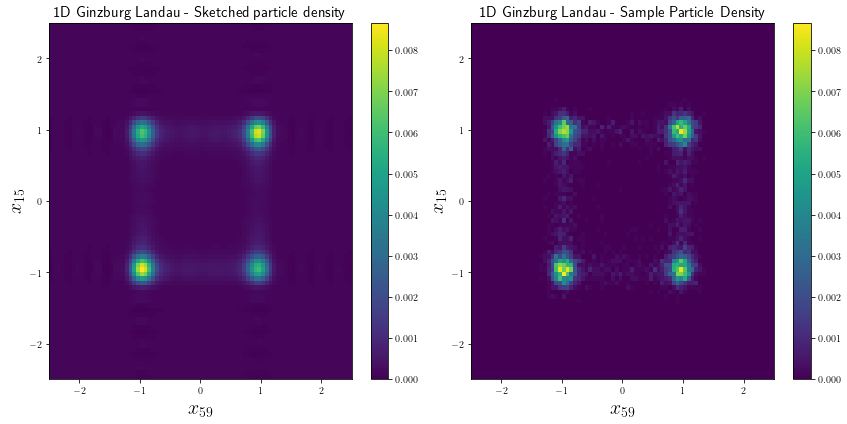

In [10]:
plt.rcParams['text.usetex'] = True

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

label_size = 20
title_size = 15

# Heatmap for htn_obtained.evaluate_marginal
im1 = axes[0].imshow(heatmap_1D, extent=[-2.5, 2.5, -2.5, 2.5], origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title("1D Ginzburg Landau - Sketched particle density", fontsize = title_size)
axes[0].set_xlabel(f"$x_{{{col1}}}$", fontsize = label_size)
axes[0].set_ylabel(f"$x_{{{col2}}}$", fontsize = label_size)

# Heatmap for particles
im2 = axes[1].imshow(hist_1D, extent=[-2.5, 2.5, -2.5, 2.5], origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title("1D Ginzburg Landau - Sample Particle Density", fontsize = title_size)
axes[1].set_xlabel(f"$x_{{{col1}}}$", fontsize = label_size)
axes[1].set_ylabel(f"$x_{{{col2}}}$", fontsize = label_size)

plt.tight_layout()

cbar = fig.colorbar(im2, ax=axes[0], orientation='vertical')

cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical')

plt.tight_layout()
plt.savefig("1D_GZ.pdf", format="pdf", dpi=300)

plt.show()

# 2D GZ plotting

Original number of batches: 6000
Number of batches after filtering: 6000


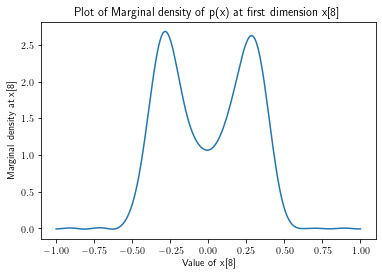

In [11]:
def int_to_bin(val, length):
    """Convert integer to binary representation with fixed length."""
    return format(val, f'0{length}b')

def interlace(i, j, l):
    """Interlace the binary representations of i and j up to length l."""
    i_bin = int_to_bin(i, l)
    j_bin = int_to_bin(j, l)
    interlaced = ''.join([a + b for a, b in zip(i_bin, j_bin)])
    return int(interlaced, 2)

def revert_interlace(k, l):
    # Convert the interlaced number back to binary.
    k_bin = int_to_bin(k, 2 * l)  # The length is doubled because it contains both i and j.
    
    # Separate the bits that belong to i and j.
    i_bits = k_bin[::2]  # Take every other bit, starting from the first
    j_bits = k_bin[1::2]  # Take every other bit, starting from the second

    # Convert these bits back to integers.
    i = int(i_bits, 2)
    j = int(j_bits, 2)

    return i, j


def transform_3d_to_2d(data):
    """Transform 3D data of shape (N, n, n) to 2D data of shape (N, n*n) using interlacing."""
    N, n, _ = data.shape
    l = int(np.log2(n))
    
    transformed_data = np.zeros((N, n*n))
    
    for i in range(n):
        for j in range(n):
            col_idx = interlace(i, j, l)
            transformed_data[:, col_idx] = data[:, i, j]
    
    return transformed_data


# Load problem parameter
d = 256
L = 8
deg = 10

# Load data
data_path = f"./Data_deposit_script/Saved_Data/2D_GZ_data_d_{d}.npz"  # This is the path from the previous code

if os.path.exists(data_path):
    with np.load(data_path) as data:
        all_samples = data['samples'][:, 1:-1, 1:-1]
else:
    raise ValueError(f"No data found at path {data_path}")


# Find batches containing NaN values
invalid_batches = np.any(np.isnan(all_samples), axis=(1,2))

# Filter out those batches
filtered_samples = all_samples[~invalid_batches]

print(f"Original number of batches: {all_samples.shape[0]}")
print(f"Number of batches after filtering: {filtered_samples.shape[0]}")

data_2d = transform_3d_to_2d(filtered_samples)
    
    
# Normalize range to [-1, 1]
y_2d = data_2d / 2.5
y_2d = y_2d[:24000, :]

# Hierarchical Tensor Sketching
core_data_path = f"./Data_deposit_script/Saved_Data/2D_GZ_data_d_{d}_solved_core.npz"
with np.load(core_data_path, allow_pickle=True) as data:
#     print(data.files)
#     print(data['c'])
    c_2d = data['c'].item()

htn_obtained_2d = FunctionalHierarchicalTensorFourier(d = d, L = L, c = c_2d, deg = deg, ghost_pt = [])

x = np.zeros([200, d])
x[:, 8] = np.linspace(-1, 1, x.shape[0])

plt.plot(x[:, 8], htn_obtained_2d.evaluate_marginal(x, mask=[x + 1 for x in range(d) if x != 8]))
# plt.ylim([-100, np.max(tt_obtained.evaluate_marginal(x, mask = [1,2]))])
plt.xlabel('Value of x[8]')
plt.ylabel('Marginal density at x[8]')
plt.title('Plot of Marginal density of p(x) at first dimension x[8]')
plt.show()



In [12]:
import numpy as np
import matplotlib.pyplot as plt

d = 256

# Parameters for columns
particle_1 = (3, 5)
particle_2 = (6, 8)
col1, col2 = interlace(particle_1[0], particle_1[1], 4), interlace(particle_2[0], particle_2[1], 4)

# Create a grid
n_grid = 80
xx, yy = np.linspace(-1, 1, n_grid), np.linspace(-1, 1, n_grid)
X, Y = np.meshgrid(xx, yy)

# Pre-allocate the heatmap matrix
heatmap = np.zeros((n_grid, n_grid))

x = np.zeros([n_grid*n_grid, d])
for i in range(n_grid):
    for j in range(n_grid):
        z_val = np.array([[X[i, j], Y[i, j]]])
        x[j*n_grid + i, [col1, col2]] = z_val
evaluated_marginal =  htn_obtained_2d.evaluate_marginal(x, mask=[x + 1 for x in range(d) if not x in [col1, col2]])
for i in range(n_grid):
    for j in range(n_grid):
        heatmap[j, i] = evaluated_marginal[j*n_grid + i]
heatmap /= heatmap.sum()

# Extract the particle positions
particles = y_2d[:, [col1, col2]]

# Create a 2D histogram for particles
hist, xedges, yedges = np.histogram2d(particles[:, 0], particles[:, 1], bins=n_grid, range=[[-1, 1], [-1, 1]])
hist /= hist.sum()  # Normalize




/Users/tangxun/Documents/GitHub/Fokker_planck_with_FHT/functional_hierarchical_tensor_fourier.py:178: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  has_none_msg = msg1 == 'None' or msg2 == 'None'


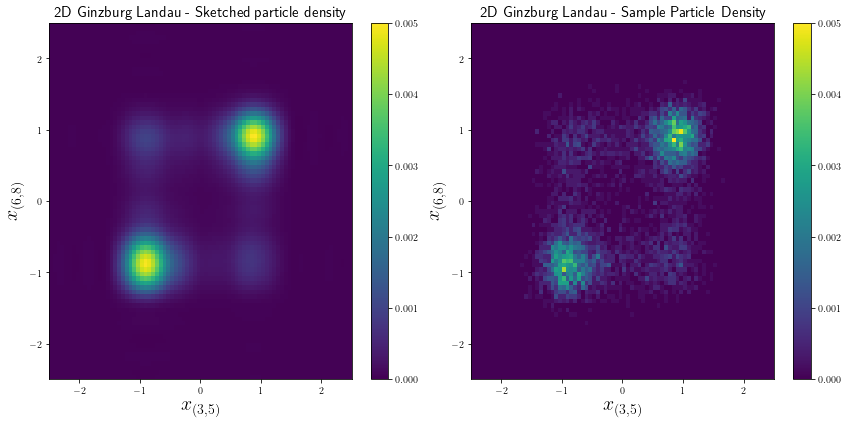

In [13]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

label_size = 20
title_size = 15

# Heatmap for htn_obtained.evaluate_marginal
im1 = axes[0].imshow(heatmap, extent=[-2.5, 2.5, -2.5, 2.5], origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title("2D Ginzburg Landau - Sketched particle density", fontsize = title_size)
axes[0].set_xlabel(f"$x_{{{particle_1[0], particle_1[1]}}}$", fontsize = label_size)
axes[0].set_ylabel(f"$x_{{{particle_2[0], particle_2[1]}}}$", fontsize = label_size)

# Heatmap for particles
im2 = axes[1].imshow(hist, extent=[-2.5, 2.5, -2.5, 2.5], origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title("2D Ginzburg Landau - Sample Particle Density", fontsize = title_size)
axes[1].set_xlabel(f"$x_{{{particle_1[0], particle_1[1]}}}$", fontsize = label_size)
axes[1].set_ylabel(f"$x_{{{particle_2[0], particle_2[1]}}}$", fontsize = label_size)

plt.tight_layout()

cbar = fig.colorbar(im2, ax=axes[0], orientation='vertical')

cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical')

plt.tight_layout()
plt.savefig("2D_GZ.pdf", format="pdf", dpi=300)

plt.show()

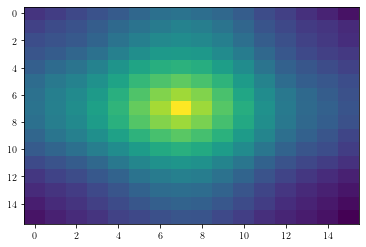

In [14]:
# Calculate two-point correlation
from copy import deepcopy
def two_pt_correlation(sample, dim):
    r'''
    Calculate the two pt correlation between target_dimension and every other dimension in the data
    '''
    data_dim = deepcopy(sample[:, dim].reshape(-1, 1))
    data_all = deepcopy(sample)
    data_dim = data_dim - np.mean(data_dim, axis = 0, keepdims = True)
    data_all = data_all - np.mean(data_all, axis = 0, keepdims = True)
    std_all = np.sqrt(np.mean(np.power(data_all, 2), axis = 0))
    std_dim = std_all[dim]
    correlation = 1/data_all.shape[0]*data_all.T@data_dim/(np.outer(std_all, std_dim))

    return correlation

dim_2d = int(np.sqrt(d))
col1 = interlace(int(dim_2d/2) - 1, int(dim_2d/2) - 1, 4)
true_correlation = np.zeros([dim_2d,dim_2d])
true_correlation_interlaced = two_pt_correlation(y_2d, dim=col1)
for i in range(dim_2d):
    for j in range(dim_2d):
        true_correlation[i, j] = true_correlation_interlaced[interlace(i, j, l = L)]

plt.imshow(true_correlation, aspect='auto', cmap='viridis')

In [15]:
from functional_hierarchical_tensor_sketch import einsum
from functional_hierarchical_tensor_sketch import child, parent

core_data_path = f"./Data_deposit_script/Saved_Data/2D_GZ_data_d_{d}_solved_core.npz"
with np.load(core_data_path, allow_pickle=True) as data:
#     print(data.files)
#     print(data['c'])
    A_dict = data['A_dict'].item()
    B_dict = data['B_dict'].item()

# Load problem parameter
d = 256
L = 8
deg = 10

def trim_custom(mat_, rank_):
    rank_ = min(rank_, mat_.shape[1], mat_.shape[0])
    rank_ = int(rank_)
    # Custom svd api.
    svd_ = np.linalg.svd
    U, S, Vh = svd_(mat_)
    V = Vh.T
    cutoff_ = 1e-3
    if S[rank_ - 1] < cutoff_ * S[0]:
        new_rank = np.sum(S > cutoff_ * S[0])
        rank_ = new_rank
    U = U[:, range(rank_)]
    S = S[range(rank_)]
    V = V[:, range(rank_)]
    return U@np.diag(S), V

r = dict()
r_level = 10 + 0*np.arange(L,0, -1)
r_level[0] = 20
r_level[1] = 18
r_level[2] = 15

W_dict = dict()
V_dict = dict()
G_dict = dict()

for l in reversed(range(0, L + 1)):
    for k in range(1, 2 ** l + 1):
        if l == L:
            r[(k, l)] = [2*deg + 1, r_level[L - 1]]
        elif l == 0:
            r[(k, l)] = [r_level[0], r_level[0]]
        else:
            r[(k, l)] = [r_level[l - 1], r_level[l], r_level[l]]
            
for l in reversed(range(0, L + 1)):
    for k in range(1, 2 ** l + 1):
        node = (k, l)
        if A_dict[node] is None:
            V_dict[node] = None
        else:
            if l == L:
                W_dict[node], V_dict[node] = trim_custom(A_dict[node], rank_=r[node][1])
            else:
                W_dict[node], V_dict[node] = trim_custom(A_dict[node], rank_=r[node][0])

# Solving for G_dict
for l in reversed(range(0, L + 1)):
    for k in range(1, 2 ** l + 1):
        node = (k, l)
        if l == L:
            G_dict[node] = B_dict[node]
        elif l != 0:
            inv1 = np.linalg.pinv(W_dict[child(node, 1)])
            inv2 = np.linalg.pinv(W_dict[child(node, 2)])
            G_dict[node] = einsum('ij, ajk, lk -> ail', inv1, B_dict[node], inv2)
        else:
            inv1 = np.linalg.pinv(W_dict[child(node, 1)])
            inv2 = np.linalg.pinv(W_dict[child(node, 2)])
            G_dict[node] = einsum('ij, jk, lk -> il', inv1, B_dict[node], inv2)

c_trial = dict()
# Solve for c
for l in reversed(range(0, L + 1)):
    for k in range(1, 2 ** l + 1):
        node = (k, l)
        if l == L:
            c_trial[node] = einsum('ba, nb -> na', V_dict[node], G_dict[node])
        elif l != 0:
            c_trial[node] = einsum('ba, bij -> aij', V_dict[node], G_dict[node])
        else:
            c_trial[node] = G_dict[node]

htn_obtained_2d_trial = FunctionalHierarchicalTensorFourier(d = d, L = L, c = c_trial, deg = deg, ghost_pt = [])

correlations_list = []
correlation_list_2d = np.zeros(d)

for ftn_used in [htn_obtained_2d, htn_obtained_2d_trial]:
# for ftn_used in [htn_obtained_2d]:
    # Create a grid
    n_grid = 30
    xx, yy = np.linspace(-1, 1, n_grid), np.linspace(-1, 1, n_grid)
    X, Y = np.meshgrid(xx, yy)
    I, J = np.indices((n_grid, n_grid))
    X_flat = X[I, J].reshape(-1, 1)  # Transforming X values into a column
    Y_flat = Y[I, J].reshape(-1, 1)  # Transforming Y values into a column
    Z_vals = np.hstack((X_flat, Y_flat))  # This is equivalent to all z_val stacked

    # Pre-allocate the heatmap matrix
    heatmap = np.zeros((n_grid, n_grid))

    for col2 in range(d):
        if col2 != col1:
            x = np.zeros([n_grid*n_grid, d])
            x[np.arange(n_grid * n_grid)[:, None], [col1, col2]] = Z_vals
            evaluated_marginal = ftn_used.evaluate_marginal(deepcopy(x), mask=[x + 1 for x in range(d) if not x in [col1, col2]])
            heatmap = evaluated_marginal.reshape(n_grid, n_grid)
            heatmap /= heatmap.sum()
            cov = np.sum(heatmap*X*Y)
            std_X = np.sqrt(np.sum(heatmap*X*X) - (np.sum(heatmap*X) ** 2))
            std_Y = np.sqrt(np.sum(heatmap*Y*Y) - (np.sum(heatmap*Y) ** 2))
            cor = cov * 1/std_X * 1/std_Y
            correlation_list_2d[col2] = cor
        else:
            correlation_list_2d[col2] = 1
    correlations_list.append(deepcopy(correlation_list_2d))

true_correlation = np.zeros([dim_2d, dim_2d])
sketched_correlation_1 = np.zeros([dim_2d, dim_2d])
sketched_correlation_2 = np.zeros([dim_2d, dim_2d])


true_correlation_interlaced = two_pt_correlation(y_2d, dim=col1)
for i in range(dim_2d):
    for j in range(dim_2d):
        true_correlation[i, j] = true_correlation_interlaced[interlace(i, j, l = 4)]
        sketched_correlation_1[i, j] = correlations_list[0][interlace(i, j, l = 4)]
        sketched_correlation_2[i, j] = correlations_list[1][interlace(i, j, l = 4)]



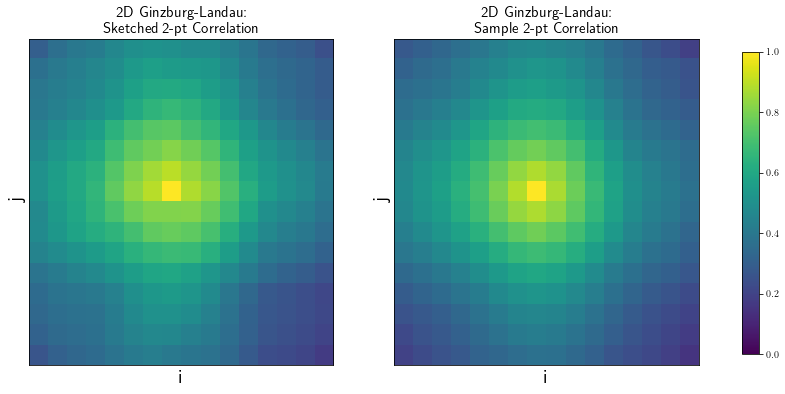

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# fig.subplots_adjust(right=0.8)

# Plot the second heatmap
label_size = 20
d = 256

axs[0].imshow(sketched_correlation_2, aspect='auto', cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(f'2D Ginzburg-Landau: \n Sketched 2-pt Correlation', fontsize=title_size, fontweight='bold')
axs[0].set_xticks([])
axs[0].set_xlabel('i', fontsize=label_size)
axs[0].set_ylabel('j', fontsize=label_size)

axs[0].set_yticks([])
# cbar = fig.colorbar(sketched_correlation_image, ax=axs[0], orientation='vertical')

# Plot the third heatmap
im = axs[1].imshow(true_correlation, aspect='auto', cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(f'2D Ginzburg-Landau: \n Sample 2-pt Correlation', fontsize=title_size, fontweight='bold')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_xlabel('i', fontsize=label_size)
axs[1].set_ylabel('j', fontsize=label_size)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # Adjust the dimensions as needed
cbar = fig.colorbar(im, cax=cbar_ax)


# Create a single colorbar for all subplots
# cbar = fig.colorbar(sketched_correlation_image, ax=axs[1], orientation='vertical')
# cbar.ax.set_ylabel('Values', fontsize=12)

plt.savefig(f"2D_GZ_2_pt_correlation_{d}.pdf", format="pdf", dpi=300)



# 3D GZ plotting

Original number of batches: 6000
Number of batches after filtering: 6000


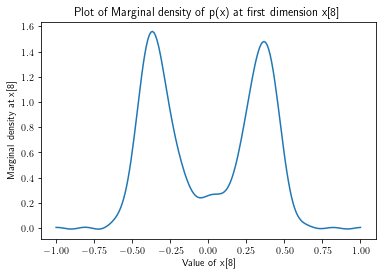

In [18]:
import numpy as np
import os
from functional_hierarchical_tensor_fourier import FunctionalHierarchicalTensorFourier
from functional_hierarchical_tensor_sketch import hier_tensor_sketch
import matplotlib.pyplot as plt


def int_to_bin(val, length):
    """Convert integer to binary representation with fixed length."""
    return format(val, f'0{length}b')

def interlace_3d(i, j, k, l):
    """Interlace the binary representations of i and j up to length l."""
    i_bin = int_to_bin(i, l)
    j_bin = int_to_bin(j, l)
    k_bin = int_to_bin(k, l)
    interlaced = ''.join([a + b + c for a, b, c in zip(i_bin, j_bin, k_bin)])
    return int(interlaced, 2)

def transform_4d_to_2d(data):
    """Transform 3D data of shape (N, n, n) to 2D data of shape (N, n*n) using interlacing."""
    N, n, _, _ = data.shape
    l = int(np.log2(n))
    
    transformed_data = np.zeros((N, n*n*n))
    
    for i in range(n):
        for j in range(n):
            for k in range(n):
                col_idx = interlace_3d(i, j, k, l)
                transformed_data[:, col_idx] = data[:, i, j, k]
    
    return transformed_data


# Load problem parameter
d = 512
L = 9
deg = 10

# Load data
data_path = f"./Data_deposit_script/Saved_Data/3D_GZ_data_d_{d}.npz"  # This is the path from the previous code

if os.path.exists(data_path):
    with np.load(data_path) as data:
        all_samples = data['samples'][:, 1:-1, 1:-1, 1:-1]
else:
    raise ValueError(f"No data found at path {data_path}")


# Find batches containing NaN values
invalid_batches = np.any(np.isnan(all_samples), axis=(1,2,3))

# Filter out those batches
filtered_samples = all_samples[~invalid_batches]

print(f"Original number of batches: {all_samples.shape[0]}")
print(f"Number of batches after filtering: {filtered_samples.shape[0]}")

data_3d = transform_4d_to_2d(filtered_samples)

    
    
# Normalize range to [-1, 1]
y_3d = data_3d / 2.5
y_3d = y_3d[:6000, :]

# y_3d = y_3d[:100]

# Hierarchical Tensor Sketching
core_data_path = f"./Data_deposit_script/Saved_Data/3D_GZ_data_d_{d}_solved_core.npz"
with np.load(core_data_path, allow_pickle=True) as data:
#     print(data.files)
#     print(data['c'])
    A_dict = data['A_dict'].item()
    B_dict = data['B_dict'].item()

from functional_hierarchical_tensor_sketch import einsum
from functional_hierarchical_tensor_sketch import child, parent

def trim_custom(mat_, rank_):
    rank_ = min(rank_, mat_.shape[1], mat_.shape[0])
    rank_ = int(rank_)
    # Custom svd api.
    svd_ = np.linalg.svd
    U, S, Vh = svd_(mat_)
    V = Vh.T
    cutoff_ = 5e-2
    if S[rank_ - 1] < cutoff_ * S[0]:
        new_rank = np.sum(S > cutoff_ * S[0])
        rank_ = new_rank
    U = U[:, range(rank_)]
    S = S[range(rank_)]
    V = V[:, range(rank_)]
    return U@np.diag(S), V

r = dict()
r_level = 20 + 0*np.arange(L,0, -1)


W_dict = dict()
V_dict = dict()
G_dict = dict()

for l in reversed(range(0, L + 1)):
    for k in range(1, 2 ** l + 1):
        if l == L:
            r[(k, l)] = [2*deg + 1, r_level[L - 1]]
        elif l == 0:
            r[(k, l)] = [r_level[0], r_level[0]]
        else:
            r[(k, l)] = [r_level[l - 1], r_level[l], r_level[l]]
            
for l in reversed(range(0, L + 1)):
    for k in range(1, 2 ** l + 1):
        node = (k, l)
        if A_dict[node] is None:
            V_dict[node] = None
        else:
            if l == L:
                W_dict[node], V_dict[node] = trim_custom(A_dict[node], rank_=r[node][1])
            else:
                W_dict[node], V_dict[node] = trim_custom(A_dict[node], rank_=r[node][0])

# Solving for G_dict
for l in reversed(range(0, L + 1)):
    for k in range(1, 2 ** l + 1):
        node = (k, l)
        if l == L:
            G_dict[node] = B_dict[node]
        elif l != 0:
            inv1 = np.linalg.pinv(W_dict[child(node, 1)])
            inv2 = np.linalg.pinv(W_dict[child(node, 2)])
            G_dict[node] = einsum('ij, ajk, lk -> ail', inv1, B_dict[node], inv2)
        else:
            inv1 = np.linalg.pinv(W_dict[child(node, 1)])
            inv2 = np.linalg.pinv(W_dict[child(node, 2)])
            G_dict[node] = einsum('ij, jk, lk -> il', inv1, B_dict[node], inv2)

c_trial = dict()
# Solve for c
for l in reversed(range(0, L + 1)):
    for k in range(1, 2 ** l + 1):
        node = (k, l)
        if l == L:
            c_trial[node] = einsum('ba, nb -> na', V_dict[node], G_dict[node])
        elif l != 0:
            c_trial[node] = einsum('ba, bij -> aij', V_dict[node], G_dict[node])
        else:
            c_trial[node] = G_dict[node]

htn_obtained_3d = FunctionalHierarchicalTensorFourier(d = d, L = L, c = c_trial, deg = deg, ghost_pt = [])


x = np.zeros([200, d])
x[:, 8] = np.linspace(-1, 1, x.shape[0])

plt.plot(x[:, 8], htn_obtained_3d.evaluate_marginal(x, mask=[x + 1 for x in range(d) if x != 8]))
# plt.ylim([-100, np.max(tt_obtained.evaluate_marginal(x, mask = [1,2]))])
plt.xlabel('Value of x[8]')
plt.ylabel('Marginal density at x[8]')
plt.title('Plot of Marginal density of p(x) at first dimension x[8]')
plt.show()





/Users/tangxun/Documents/GitHub/Fokker_planck_with_FHT/functional_hierarchical_tensor_fourier.py:178: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  has_none_msg = msg1 == 'None' or msg2 == 'None'


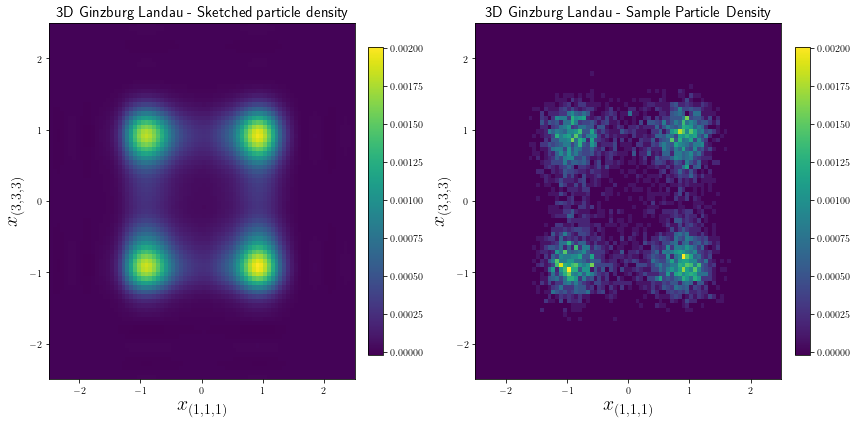

In [20]:
import numpy as np
import matplotlib.pyplot as plt

d = 512
particle_1 = (1,1,1)
particle_2 = (3,3,3)
# Parameters for columns
col1, col2 = interlace_3d(particle_1[0], particle_1[1], particle_1[2], l = 3), interlace_3d(particle_2[0], particle_2[1], particle_2[2], l = 3)

# Create a grid
n_grid = 80
xx, yy = np.linspace(-1, 1, n_grid), np.linspace(-1, 1, n_grid)
X, Y = np.meshgrid(xx, yy)

# Pre-allocate the heatmap matrix
heatmap = np.zeros((n_grid, n_grid))

x = np.zeros([n_grid*n_grid, d])
for i in range(n_grid):
    for j in range(n_grid):
        z_val = np.array([[X[i, j], Y[i, j]]])
        x[j*n_grid + i, [col1, col2]] = z_val
evaluated_marginal =  htn_obtained_3d.evaluate_marginal(x, mask=[x + 1 for x in range(d) if not x in [col1, col2]])
for i in range(n_grid):
    for j in range(n_grid):
        heatmap[j, i] = evaluated_marginal[j*n_grid + i]
heatmap /= heatmap.sum()
# Extract the particle positions
particles = y_3d[:, [col1, col2]]

# Create a 2D histogram for particles
hist, xedges, yedges = np.histogram2d(particles[:, 0], particles[:, 1], bins=n_grid, range=[[-1, 1], [-1, 1]])
hist /= hist.sum()  # Normalize

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Heatmap for htn_obtained.evaluate_marginal
im1 = axes[0].imshow(heatmap, extent=[-2.5, 2.5, -2.5, 2.5], origin='lower', aspect='auto', cmap='viridis')
axes[0].set_title("3D Ginzburg Landau - Sketched particle density", fontsize = title_size)
axes[0].set_xlabel(f"$x_{{{particle_1[0], particle_1[1], particle_1[2]}}}$", fontsize = label_size)
axes[0].set_ylabel(f"$x_{{{particle_2[0], particle_2[1], particle_2[2]}}}$", fontsize = label_size)

# Heatmap for particles
im2 = axes[1].imshow(hist, extent=[-2.5, 2.5, -2.5, 2.5], origin='lower', aspect='auto', cmap='viridis')
axes[1].set_title("3D Ginzburg Landau - Sample Particle Density", fontsize = title_size)
axes[1].set_xlabel(f"$x_{{{particle_1[0], particle_1[1], particle_1[2]}}}$", fontsize = label_size)
axes[1].set_ylabel(f"$x_{{{particle_2[0], particle_2[1], particle_2[2]}}}$", fontsize = label_size)


fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()

plt.savefig("3D_GZ.pdf", format="pdf", dpi=300)
plt.show()

